# Introducción a la solución en diferencias finitas de PDEs

##  Ecuación de Burgers

Podemos leer acerca de la ecuacion de Burgers en su [pagina wikipedia](http://en.wikipedia.org/wiki/Burgers'_equation).
La misma en una dimension espacial luce como sigue:

$$
\begin{equation}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial ^2u}{\partial x^2}
\end{equation}
$$

Como vemos, es una combinacion de la conveccion no lineal y la difusion. 

Empleando un esquema en diferencias hacia adelante para el tiempo, hacia atras para el espacio y nuestro metodo de segundo orden para la derivada segunda, resulta la discretizacion siguiente:

$$
\begin{equation}
\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n \frac{u_i^n - u_{i-1}^n}{\Delta x} = \nu \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}
\end{equation}
$$

Como antes, una vez que tenemos la condicion inicial dada, la unica incognita es $u_i^{n+1}$. Avanzamos un paso de tiempo como sigue:

$$
\begin{equation}
u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)
\end{equation}
$$

### Condiciones Iniciales y Frontera

La condicion inicial para este problema sera:

$$
\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi(t=0) = \phi_0 &=& \exp \bigg(\frac{-x^2}{4 \nu} \bigg) + \exp \bigg(\frac{-(x-2 \pi)^2}{4 \nu} \bigg)
\end{eqnarray}
$$

Asi formulado, este problema presenta solucion analitica, dada por:

$$
\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-(x-4t)^2}{4 \nu (t+1)} \bigg) + \exp \bigg(\frac{-(x-4t -2 \pi)^2}{4 \nu(t+1)} \bigg)
\end{eqnarray}
$$

La condicion de borde sera:

$$
\begin{equation}
u(0) = u(2\pi)
\end{equation}
$$

Se trata de una condicion de borde tipo *periodica*.

### Ahorrando tiempo con SymPy

A fin de evitar la tarea tediosa de evaluar a mano la derivada $\frac{\partial \phi}{\partial x}$ que requerimos para la condicion inicial, usamos la libreria de matematica simbolica para Python [SymPy](http://sympy.org/en/).

In [56]:
import numpy
import sympy
from matplotlib import pyplot
%matplotlib inline

In [57]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

Especificamos a SymPy que deseamos salida en formato $\LaTeX$:

In [58]:
sympy.init_printing()

Ahora, fijemos `x` como una variable *simbolica*:

In [59]:
x = sympy.symbols('x')

Veamos que sucede cuando tipeamos `x` en una celda de codigo:

In [60]:
x

El valor de `x` is $x$. Sympy es referido tambien como un sistema de computacion algebraica! El valor de `5*x` sera:

In [61]:
5 * x

Este sistema entonces nos permite manipular una ecuacion con incognitas empleando Python! Comenzamos definiendo simbolos para $x$, $\nu$ y $t$. Luego, escribimos la ecuacion total para $\phi$:

In [62]:
x, nu, t = sympy.symbols('x nu t')
phi = (sympy.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sympy.exp(-(x - 4 * t - 2 * sympy.pi)**2 / (4 * nu * (t + 1))))
phi

Ahora evaluemos nuestra derivada parcial $\frac{\partial \phi}{\partial x}$. Para ello diferenciamos con respecto a $x$:

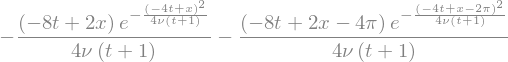

In [63]:
phiprime = phi.diff(x)
phiprime

Si deseamos ver la version *cruda*, usamos:

In [64]:
print(phiprime)

-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 4*pi)*exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1)))/(4*nu*(t + 1))


###  Lambdify

Ahora que disponemos de una version *Pythonic* para nuestra derivada, escribimos la ecuacion para la condicion inicial y procuramos traducirla en una expresion que Python pueda utilizar. Para ello, usaremos la funcion *lambdify*, la cual toma una ecuacion simbolica **SymPy** y la transforma en una funcion que podamos invocar.  

In [65]:
from sympy.utilities.lambdify import lambdify

u = -2 * nu * (phiprime / phi) + 4
print(u)

-2*nu*(-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 4*pi)*exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)))/(exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1))) + exp(-(-4*t + x)**2/(4*nu*(t + 1)))) + 4


In [66]:
u_lamb = lambdify((t, x, nu), u)
print('The value of u at t=1, x=4, nu=3 is {}'.format(u_lamb(1, 4, 3)))

The value of u at t=1, x=4, nu=3 is 3.49170664206445


### Regresando a la ecuacion de Burgers

Ahora que tenemos establecida la condicion inicial, procedemos a implementar la misma en nuestro problema.

In [67]:
# Set parameters.
nx = 101  # number of spatial grid points
L = 2.0 * numpy.pi  # length of the domain
dx = L / (nx - 1)  # spatial grid size
nu = 0.07  # viscosity
nt = 100  # number of time steps to compute
sigma = 0.1  # CFL limit
dt = sigma * dx**2 / nu  # time-step size

# Discretize the domain.
x = numpy.linspace(0.0, L, num=nx)

Disponemos de una funcion `u_lamb` pero necesitamos generar un vector `u0` con nuestra condicion inicial. La funcion `u_lamb` devuelve el valor de `u` para un dado instante $t$, posicion $x$ y $nu$. Es posible emplear un bucle `for` para movernos a traves de valores de `x` a fin de generar el vector `u0`. Este codigo seria como sigue:

```Python
u0 = numpy.empty(nx)

for i, x0 in enumerate(x):
    u0[i] = u_lamb(t, x0, nu)
```

Una forma alternativa mas *elegante* de codificar esto se consigue usando *list comprehension*:

```Python
[u_lamb(t, x0, nu) for x0 in x]
```

Este proceso crea una *lista* la cual es posible convertir en *vector* usando `numpy.asarray()`:

```Python
u = numpy.asarray([u_lamb(t, x0, nu) for x0 in x])
```

In [68]:
# Set initial conditions.
t = 0.0
u0 = numpy.array([u_lamb(t, xi, nu) for xi in x])
u0

array([4.        , 4.06283185, 4.12566371, 4.18849556, 4.25132741,
       4.31415927, 4.37699112, 4.43982297, 4.50265482, 4.56548668,
       4.62831853, 4.69115038, 4.75398224, 4.81681409, 4.87964594,
       4.9424778 , 5.00530965, 5.0681415 , 5.13097336, 5.19380521,
       5.25663706, 5.31946891, 5.38230077, 5.44513262, 5.50796447,
       5.57079633, 5.63362818, 5.69646003, 5.75929189, 5.82212374,
       5.88495559, 5.94778745, 6.0106193 , 6.07345115, 6.136283  ,
       6.19911486, 6.26194671, 6.32477856, 6.38761042, 6.45044227,
       6.51327412, 6.57610598, 6.63893783, 6.70176967, 6.76460125,
       6.82742866, 6.89018589, 6.95176632, 6.99367964, 6.72527549,
       4.        , 1.27472451, 1.00632036, 1.04823368, 1.10981411,
       1.17257134, 1.23539875, 1.29823033, 1.36106217, 1.42389402,
       1.48672588, 1.54955773, 1.61238958, 1.67522144, 1.73805329,
       1.80088514, 1.863717  , 1.92654885, 1.9893807 , 2.05221255,
       2.11504441, 2.17787626, 2.24070811, 2.30353997, 2.36637

Grafiquemos ahora nuestra condicion inicial $u(x,0)$:

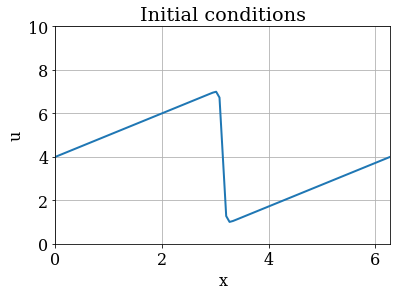

In [69]:
# Plot the initial conditions.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.title('Initial conditions')
pyplot.xlabel('x')
pyplot.ylabel('u')
pyplot.grid()
pyplot.plot(x, u0, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 10.0);

### Condiciones de borde Periodicas

En el caso del problema de adveccion ya tratado, si dejamos correr la simulacion un periodo de tiempo considerable (incrementando `nt`) notaremos que la onda continuara moviendose hacia la derecha hasta *desaparecer* de la figura. 

Empleando condiciones de borde **periodicas**, cuando un punto alcanza el lado derecho de la figura, el mismo se solapa al frente de la misma. Recordemos la discretizacion que obtuvimos al comienzo de este cuaderno:

$$
\begin{equation}
u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)
\end{equation}
$$

Cual es la *interpretacion* para $u_{i+1}^n$ cuando $i$ alcanza el final de la figura?

In [70]:
# Integrate the Burgers' equation in time.
u = u0.copy()
for n in range(nt):
    un = u.copy()
    # Update all interior points.
    u[1:-1] = (un[1:-1] -
               un[1:-1] * dt / dx * (un[1:-1] - un[:-2]) +
               nu * dt / dx**2 * (un[2:] - 2 * un[1:-1] + un[:-2]))
    # Update boundary points.
    u[0] = (un[0] -
            un[0] * dt / dx * (un[0] - un[-1]) +
            nu * dt / dx**2 * (un[1] - 2 * un[0] + un[-1]))
    u[-1] = (un[-1] -
            un[-1] * dt / dx * (un[-1] - un[-2]) +
            nu * dt / dx**2 * (un[0] - 2 * un[-1] + un[-2]))

In [71]:
# Compute the analytical solution.
u_analytical = numpy.array([u_lamb(nt * dt, xi, nu) for xi in x])

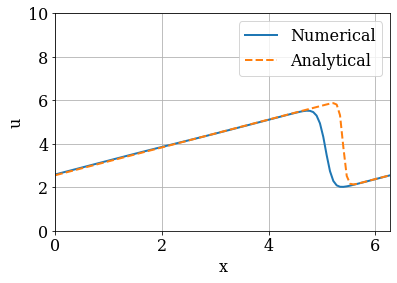

In [73]:
# Plot the numerical solution along with the analytical solution.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('x')
pyplot.ylabel('u')
pyplot.grid()
pyplot.plot(x, u, label='Numerical',
            color='C0', linestyle='-', linewidth=2)
pyplot.plot(x, u_analytical, label='Analytical',
            color='C1', linestyle='--', linewidth=2)
pyplot.legend()
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 10.0);

Generemos ahora una animacion (usando el modulo `animation` de Matplotlib) que nos permita visualizar el cambio temporal de la solucion numerica con respecto a la solucion analitica.

In [74]:
from matplotlib import animation
from IPython.display import HTML

Creamos la funcion `burgers` para calcular la solucion numerica de la ecuacion de Burgers 1D a lo largo del tiempo. Esta funcion devuelve la *historia* de la solucion: una lista con `nt` elementos, cada uno describe la solucion en el dominio espacial en un determinado paso de tiempo.

In [75]:
def burgers(u0, dx, dt, nu, nt=20):
    """
    Computes the numerical solution of the 1D Burgers' equation
    over the time steps.
    
    Parameters
    ----------
    u0 : numpy.ndarray
        The initial conditions as a 1D array of floats.
    dx : float
        The grid spacing.
    dt : float
        The time-step size.
    nu : float
        The viscosity.
    nt : integer, optional
        The number of time steps to compute;
        default: 20.
    
    Returns
    -------
    u_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    u_hist = [u0.copy()]
    u = u0.copy()
    for n in range(nt):
        un = u.copy()
        # Update all interior points.
        u[1:-1] = (un[1:-1] -
                   un[1:-1] * dt / dx * (un[1:-1] - un[:-2]) +
                   nu * dt / dx**2 * (un[2:] - 2 * un[1:-1] + un[:-2]))
        # Update boundary points.
        u[0] = (un[0] -
                un[0] * dt / dx * (un[0] - un[-1]) +
                nu * dt / dx**2 * (un[1] - 2 * un[0] + un[-1]))
        u[-1] = (un[-1] -
                un[-1] * dt / dx * (un[-1] - un[-2]) +
                nu * dt / dx**2 * (un[0] - 2 * un[-1] + un[-2]))
        u_hist.append(u.copy())
    return u_hist

In [76]:
# Compute the history of the numerical solution.
u_hist = burgers(u0, dx, dt, nu, nt=nt)

In [77]:
# Compute the history of the analytical solution.
u_analytical = [numpy.array([u_lamb(n * dt, xi, nu) for xi in x])
                for n in range(nt)]

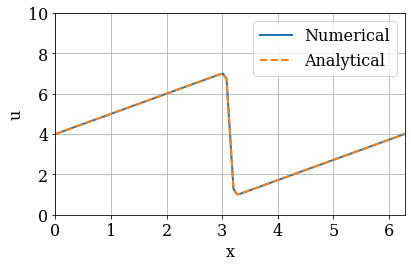

In [78]:
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('x')
pyplot.ylabel('u')
pyplot.grid()
u0_analytical = numpy.array([u_lamb(0.0, xi, nu) for xi in x])
line1 = pyplot.plot(x, u0, label='Numerical',
                    color='C0', linestyle='-', linewidth=2)[0]
line2 = pyplot.plot(x, u0_analytical, label='Analytical',
                    color='C1', linestyle='--', linewidth=2)[0]
pyplot.legend()
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 10.0)
fig.tight_layout()

In [79]:
def update_plot(n, u_hist, u_analytical):
    """
    Update the lines y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    u_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    u_analytical : list of numpy.ndarray objects
        The history of the analytical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line1.set_ydata(u_hist[n])
    line2.set_ydata(u_analytical[n])

In [80]:
# Create an animation.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(u_hist, u_analytical),
                               interval=100)

In [81]:
# Display the video.
HTML(anim.to_jshtml())

<div class="alert alert-block alert-danger">
<h2>Array Operation Speed Increase</h2>
</div>

<div class="alert alert-block alert-success">
Coding up discretization schemes using array operations can be a bit of a pain.  It requires much more mental effort on the front-end than using two nested `for` loops.  So why do we do it?  Because it's fast.  Very, very fast.

Here's what the Burgers code looks like using two nested `for` loops.  It's easier to write out, plus we only have to add one "special" condition to implement the periodic boundaries.  

At the top of the cell, you'll see the decorator `%%timeit`.
This is called a "cell magic".  It runs the cell several times and returns the average execution time for the contained code.  

Let's see how long the nested `for` loops take to finish.
</div>    

In [82]:
%%timeit
# Set initial conditions.
u = numpy.array([u_lamb(t, x0, nu) for x0 in x])
# Integrate in time using a nested for loop.
for n in range(nt):
    un = u.copy()
    # Update all interior points and the left boundary point.
    for i in range(nx - 1):
        u[i] = (un[i] -
                un[i] * dt / dx *(un[i] - un[i - 1]) +
                nu * dt / dx**2 * (un[i + 1] - 2 * un[i] + un[i - 1]))
    # Update the right boundary.
    u[-1] = (un[-1] -
             un[-1] * dt / dx * (un[-1] - un[-2]) +
             nu * dt / dx**2 * (un[0]- 2 * un[-1] + un[-2]))

29.5 ms ± 662 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<div class="alert alert-block alert-success">
Less than 50 milliseconds.  Not bad, really.  

Now let's look at the array operations code cell.  Notice that we haven't changed anything, except we've added the `%%timeit` magic and we're also resetting the array `u` to its initial conditions.  

This takes longer to code and we have to add two special conditions to take care of the periodic boundaries.  Was it worth it?
</div>

In [83]:
%%timeit
# Set initial conditions.
u = numpy.array([u_lamb(t, xi, nu) for xi in x])
# Integrate in time using array operations.
for n in range(nt):
    un = u.copy()
    # Update all interior points.
    u[1:-1] = (un[1:-1] -
               un[1:-1] * dt / dx * (un[1:-1] - un[:-2]) +
               nu * dt / dx**2 * (un[2:] - 2 * un[1:-1] + un[:-2]))
    # Update boundary points.
    u[0] = (un[0] -
            un[0] * dt / dx * (un[0] - un[-1]) +
            nu * dt / dx**2 * (un[1] - 2 * un[0] + un[-1]))
    u[-1] = (un[-1] -
            un[-1] * dt / dx * (un[-1] - un[-2]) +
            nu * dt / dx**2 * (un[0] - 2 * un[-1] + un[-2]))

4.17 ms ± 82.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<div class="alert alert-block alert-success">
Yes, it is absolutely worth it.  That's a nine-fold speed increase.  For this exercise, you probably won't miss the extra 40 milliseconds if you use the nested `for` loops, but what about a simulation that has to run through millions and millions of iterations?  Then that little extra effort at the beginning will definitely pay off. 
</div>

###### The cell below loads the style of the notebook.

In [54]:
from IPython.core.display import HTML
css_file = '.././styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())